STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

# Linear Regression with Gradient Descent

![](figures/adaline-concept.png)

Note that linear regression and Adaline are very similar. The only difference is that we apply a threshold function for converting the outputs from continuous targets for predictions. The derivative and training procedure are identical to Adaline though. You can compare the two notebooks (this one and `adaline-sgd.ipynb`) side by side as shown below to see the relationship:

![](figures/adaline-vs-linreg.png)

In [291]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Load & Prepare a Toy Dataset

In [302]:
df = pd.read_csv('ENB2012_data.csv', index_col=False)
df.tail()
print(df.dtypes)

X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y1    float64
Y2    float64
dtype: object


In [303]:
# Assign features and target

X = torch.tensor(df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].values, dtype=torch.float)
y = torch.tensor(df['Y2'].values, dtype=torch.float)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

# Normalize (mean zero, unit variance), standardization.

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

## Implement Linear Regression Model

In [304]:
class LinearRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):

        # (yhat - y)^2  --> this is our loss function
        # deriv: 2*(y - yhat)
        
        grad_loss_yhat = 2*(y - yhat)
        
        grad_yhat_weights = -x
        grad_yhat_bias = -1.
        
        # Chain rule: inner times outer
        grad_loss_weights =  torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

## Define Training and Evaluation Functions

In [305]:
####################################################
##### Training and evaluation wrappers
###################################################

def loss(yhat, y): # mean squared error
    return torch.mean((yhat - y)**2)

# Batch Gradient Descent
def train(model, x, y, num_epochs, learning_rate=0.01):
    cost = []
    for e in range(num_epochs):

        #### Compute outputs ####
        yhat = model.forward(x)

        #### Compute gradients ####
        negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

        #### Update weights and bias ####
        model.weights += learning_rate * negative_grad_w
        model.bias += learning_rate * negative_grad_b

        #### Logging ####
        yhat = model.forward(x) # note that this is a bit wasteful here
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

## Train Linear Regression Model

In [306]:
model = LinearRegression1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train, 
             num_epochs=200,
             learning_rate=0.05)

Epoch: 001 | MSE: 536.39227
Epoch: 002 | MSE: 427.21774
Epoch: 003 | MSE: 344.45737
Epoch: 004 | MSE: 279.70889
Epoch: 005 | MSE: 228.19989
Epoch: 006 | MSE: 186.87184
Epoch: 007 | MSE: 153.56898
Epoch: 008 | MSE: 126.67381
Epoch: 009 | MSE: 104.92837
Epoch: 010 | MSE: 87.33533
Epoch: 011 | MSE: 73.09612
Epoch: 012 | MSE: 61.56806
Epoch: 013 | MSE: 52.23269
Epoch: 014 | MSE: 44.67114
Epoch: 015 | MSE: 38.54483
Epoch: 016 | MSE: 33.57999
Epoch: 017 | MSE: 29.55510
Epoch: 018 | MSE: 26.29100
Epoch: 019 | MSE: 23.64273
Epoch: 020 | MSE: 21.49301
Epoch: 021 | MSE: 19.74689
Epoch: 022 | MSE: 18.32757
Epoch: 023 | MSE: 17.17287
Epoch: 024 | MSE: 16.23246
Epoch: 025 | MSE: 15.46561
Epoch: 026 | MSE: 14.83934
Epoch: 027 | MSE: 14.32697
Epoch: 028 | MSE: 13.90689
Epoch: 029 | MSE: 13.56159
Epoch: 030 | MSE: 13.27690
Epoch: 031 | MSE: 13.04135
Epoch: 032 | MSE: 12.84566
Epoch: 033 | MSE: 12.68230
Epoch: 034 | MSE: 12.54518
Epoch: 035 | MSE: 12.42936
Epoch: 036 | MSE: 12.33084
Epoch: 037 | MSE: 1

## Evaluate Linear Regression Model

### Plot MSE

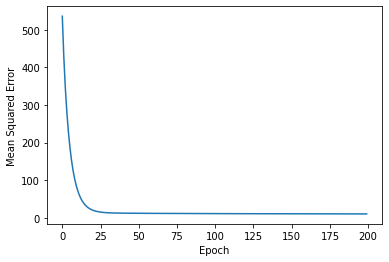

In [307]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [298]:
train_pred = model.forward(X_train)
test_pred = model.forward(X_test)

print('Train MSE: %.5f' % loss(train_pred, y_train))
print('Test MSE: %.5f' % loss(test_pred, y_test))

Train MSE: 10.02526
Test MSE: 14.37849


### Compare with analytical solution

In [299]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[-1.9090],
        [-1.1661],
        [ 1.4941],
        [-1.8580],
        [ 6.6503],
        [ 0.1809],
        [ 2.0131],
        [ 0.0248]])
Bias tensor([24.5209])


In [300]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train)
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[-8.3062e+00],
        [-1.1436e+01],
        [ 3.2026e+00],
        [ 2.1229e+00],
        [ 6.6581e+00],
        [ 1.9686e-01],
        [ 2.0146e+00],
        [ 8.6998e-03]])
Analytical bias tensor([24.5209])


## (Ungraded) HW Exercises

Modify the `train()` function such that the dataset is shuffled prior to each epoch. Do you see a difference -- Yes/No? Try to come up with an explanation for your observation.

